\title{Operatial Amplifier Topology Repository for use with Python}
\author{Steven K Armour}
\maketitle

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Premise" data-toc-modified-id="Premise-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Premise</a></span></li><li><span><a href="#Libarys" data-toc-modified-id="Libarys-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Libarys</a></span></li><li><span><a href="#Setup" data-toc-modified-id="Setup-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Setup</a></span></li><li><span><a href="#Ideal-OpAmp" data-toc-modified-id="Ideal-OpAmp-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Ideal OpAmp</a></span></li><li><span><a href="#TestBench" data-toc-modified-id="TestBench-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>TestBench</a></span></li><li><span><a href="#Buffer" data-toc-modified-id="Buffer-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Buffer</a></span></li><li><span><a href="#Inverting" data-toc-modified-id="Inverting-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Inverting</a></span></li><li><span><a href="#Noninverting" data-toc-modified-id="Noninverting-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Noninverting</a></span></li><li><span><a href="#Miller-Capactive-Integrator" data-toc-modified-id="Miller-Capactive-Integrator-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Miller Capactive Integrator</a></span></li><li><span><a href="#Miller-Inductive-Integrator" data-toc-modified-id="Miller-Inductive-Integrator-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Miller Inductive Integrator</a></span></li><li><span><a href="#Low-Pass-1Pole" data-toc-modified-id="Low-Pass-1Pole-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Low Pass 1Pole</a></span></li><li><span><a href="#Miller-Capacitive-Differentiator" data-toc-modified-id="Miller-Capacitive-Differentiator-12"><span class="toc-item-num">12&nbsp;&nbsp;</span>Miller Capacitive Differentiator</a></span></li><li><span><a href="#Miller-Inductive-Differentiator" data-toc-modified-id="Miller-Inductive-Differentiator-13"><span class="toc-item-num">13&nbsp;&nbsp;</span>Miller Inductive Differentiator</a></span></li><li><span><a href="#High-Pass-1Zero" data-toc-modified-id="High-Pass-1Zero-14"><span class="toc-item-num">14&nbsp;&nbsp;</span>High Pass 1Zero</a></span></li></ul></div>

Note:
this notebook uses the [`(some) LaTeX environments for Jupyter
`](http://jupyter-contrib-nbextensions.readthedocs.io/en/latest/nbextensions/latex_envs/README.html) found within the install of https://github.com/ipython-contrib/jupyter_contrib_nbextensions

And all diagrams are made in **draw.io** where the source file is `OpAmpTobosDrawing.html` where that file and the exported files should accompany this notebook from its GitHub source



# Premise
This Notebook serves as a Repository of Operational Amplifier Topologies for use in [PySpice](https://pyspice.fabrice-salvaire.fr/) and for the topologies theory. The Goal for the Author personally is to make one or two upgrades to this notebook a week. Whether that be a new feature, expanded theory, or new topology.

Some of the intended upgrades include:
\begin{itemize}
\item Enhanced analyses of output data
\item Routines to find figures of merits from output data
\item Added calculations from theory 
\item Simulations from theory and compersion to SPICE sim
\item adding GUI interactivity via ipython notebook widgets
\end{itemize}



# Libarys

In [1]:
from sympy import *
init_printing()
import ipywidgets as wgs

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from PySpice.Plot.BodeDiagram import bode_diagram
from PySpice.Probe.Plot import plot
from PySpice.Spice.Netlist import Circuit
from PySpice.Spice.Netlist import SubCircuitFactory
from PySpice.Unit import *

#https://github.com/jrjohansson/version_information
%load_ext version_information
%version_information sympy, numpy, matplotlib, pandas, PySPice

Software versions
Python 3.6.3 64bit [GCC 7.2.0]
IPython 6.2.1
OS Linux 4.13.0 38 generic x86_64 with debian stretch sid
sympy 1.1.2.dev
numpy 1.13.3
matplotlib 2.1.0
pandas 0.21.0
PySPice 1.2.0
Wed Apr 25 20:11:14 2018 MDT

# Setup

In [2]:
def lambdify2(expresion, ReVars=False):
    """
    Helper Function to more automate sympy `lambdify` function
    
    Args:
        expresion: sympy expresion !Only Pass LHS of Equations
        ReVars (bool; False): Control to return the Vars in a list if True
    
    Note:
        lambdfy is set with `dummify=False` therefore do not pass
        unsantied variabls to functin else error will be thrown
    """
    #collect vars
    Vars=sorted(list(expresion.free_symbols), key=lambda x: str(x))
    #perform lambdfy with waver
    F=lambdify(Vars, expresion, dummify=False)
    if ReVars:
        return F, Vars
    else:
        return F

# Ideal OpAmp

Using the Semi Ideal OpAmp model devloped by Fabrice Salvaire for the OpAmp Exsample [8.10.3. Operational Amplifier](https://pyspice.fabrice-salvaire.fr/examples/operational-amplifier/operational-amplifier.html)

<img src="SemiIdelOpAmpModel.png">

In [3]:
class BasicOperationalAmplifier(SubCircuitFactory):
    """
    Semi Ideal OpAmp Model SubCir from 
    https://pyspice.fabrice-salvaire.fr/examples/operational-amplifier/operational-amplifier.html
    A0=100e3; pole=100; A=10e6Hz
    Termanals:
        non_inverting_input
        inverting_input
        output
    """

    __name__ = 'BasicOperationalAmplifier'
    __nodes__ = ('non_inverting_input', 'inverting_input', 'output')

    ##############################################

    def __init__(self):

        super().__init__()

        # Input impedance
        self.R('input', 'non_inverting_input', 'inverting_input', 10@u_MΩ)

        # dc gain=100k and pole1=100hz
        # unity gain = dcgain x pole1 = 10MHZ
        self.VCVS('gain', 1, self.gnd, 'non_inverting_input', 'inverting_input', voltage_gain=kilo(100))
        self.R('P1', 1, 2, 1@u_kΩ)
        self.C('P1', 2, self.gnd, 1.5915@u_uF)

        # Output buffer and resistance
        self.VCVS('buffer', 3, self.gnd, 2, self.gnd, 1)
        self.R('out', 3, 'output', 10@u_Ω)

# TestBench

<img src="TestBench1P.png">

In [4]:
class OnePortOpAmpTB(Circuit):
    """
    Class for implimenting Bode plot simulation for One Port 
    (Two Termanal) Opertinal Amplifer topology 
    """
    def __init__(self, DUT, **kwargs):
        """
        Args:
            DUT (class SubCircuitFactory): The One Port OpAmp topology class to be tested
            kwargs (dict): Addital Ciricut Parmters to the topology under test
        """
        #bind the DUT class to TB instance
        self.DUT=DUT
        #self.Theory=self.DUT.Theory()
        #create the ciruit name from DUT name
        super().__init__(title=f'{self.DUT.__name__}_TB', **kwargs)
        
    
    def SetupCir(self, **kwargs):
        """
        Sets up the the DUT and the Testbench for simulation
        see diagrm in source IPYNB for cirucit diagram
        Args:
            kwargs (dict): Addital Ciricut Parmters to the topology under test
        """
        #create instatince of DUT and setuo with parmaters
        self.DUT=self.DUT(**kwargs)
        
        #load the DUT in to the circuit
        self.subcircuit(self.DUT)
        self.X('Amp', self.DUT.__name__, 'Vin', 'Vout')
        
        #set up the TB elements
        self.R('Sload', 'Vin' , '1', 50@u_Ω)
        self.SinusoidalVoltageSource('Source', '1', self.gnd, amplitude=1@u_V)

        self.R('Tload', 'Vout', self.gnd, 50@u_Ω)
        #print out the resulting spice list
        print(self)
    
    def Simulate(self, fMin=1, fMax=100e3):
        """
        Method to perform a Bode plot simulation via NgSpice AC sim @25C
        Args:
            fMin(float; 1 [Hz]): the  starting frequnacy for 
            Bode plot sweep in hertz
            
            fMax(float; 100e3[Hz]): the ending  frequnacy for 
            Bode plot sweep in hertz
        
        Retured Attributes:
            results: the ac simulation raw results from NGSpice
            Data: Pandas Dataframe with ouputs and calcs from results
            
        """
        
        simulator = self.simulator(temperature=25, nominal_temperature=25)
        self.results = simulator.ac(start_frequency=fMin@u_Hz, stop_frequency=fMax@u_Hz, number_of_points=10,  variation='dec')
        
        # returned dataframe
        self.Data=pd.DataFrame()
        self.Data['freq[Hz]']=self.results.frequency
        self.Data['Vin']=self.results.Vin
        self.Data['Vout']=self.results.Vout
        #normlized gain in dB
        self.Data['Gain[dB]']=20*np.log10(np.abs(self.Data['Vout']/self.Data['Vin']))
        # phase in radians unwraped
        self.Data['Phase[rad_UW]']=(np.angle(self.Data['Vout']))
    
    def PlotResults(self):
        """
        Create a Bode plot from the simulation
        """
        self.fig, [self.axMag, self.axPh]=plt.subplots(ncols=1, nrows=2, sharex=True)

        plt.suptitle("Bode Diagram of an Operational Amplifier")
        bode_diagram(axes=(self.axMag, self.axPh),
                     frequency=self.Data['freq[Hz]'],
                     gain=self.Data['Gain[dB]'],
                     phase=self.Data['Phase[rad_UW]'],
                     marker='.',
                     color='blue',
                     linestyle='-',
                    )
        
        
    

# Buffer

<img src="Buffer.png">

In [5]:
class BufferOpAmp(SubCircuitFactory):
    """
    Buffer OpAmp SubCircuit
    Termanals:
        Vin
        Vout
    
    """
    
    __name__='BufferOpAmp'
    __nodes__=('Vin','Vout')
    
    def __init__(self):
        super().__init__()
       
        #'non_inverting_input', 'inverting_input', 'output'
        self.subcircuit(BasicOperationalAmplifier())
        self.X('op', 'BasicOperationalAmplifier', 'Vin', 'Vout', 'Vout')
    
    @staticmethod
    def Theory():
        """Practical Electrical Engineering Sergey Makarov; V-235"""
        s=symbols('s')
        H=Function('H')(s); Rin=Function('R_in')(s); Rout=Function('R_out')(s)
        TF=Eq(H, 1); Rin=Eq(Rin, oo); Rout=Eq(Rout, 0)
        return TF, Rin, Rout
    

In [6]:
#Print out the Buffer Op Amp Theory
BufferOpAmp.Theory()

.title BufferOpAmp_TB
.subckt BufferOpAmp Vin Vout
.subckt BasicOperationalAmplifier non_inverting_input inverting_input output
Rinput non_inverting_input inverting_input 10MegOhm
Egain 1 0 non_inverting_input inverting_input 100k
RP1 1 2 1kOhm
CP1 2 0 1.5915uF
Ebuffer 3 0 2 0 1
Rout 3 output 10Ohm
.ends BasicOperationalAmplifier
Xop Vin Vout Vout BasicOperationalAmplifier
.ends BufferOpAmp
XAmp Vin Vout BufferOpAmp
RSload Vin 1 50Ohm
VSource 1 0 DC 0V AC SIN(0V 1V 50Hz 0s 0Hz)
RTload Vout 0 50Ohm



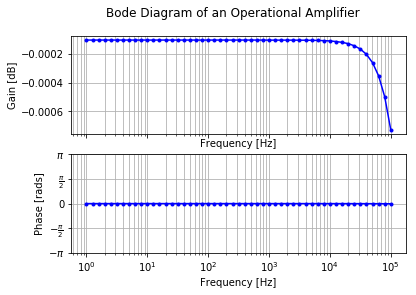

In [7]:
#create the Test Bench and Bind to this instance the BufferOpAmp Topo
TB=OnePortOpAmpTB(BufferOpAmp)
#Setup the Testbench and print the TB
TB.SetupCir()
#Run the AC Bode Simulation
TB.Simulate()
#View Bode Simulation
TB.PlotResults()

# Inverting

<img src="InvertingOpAmp.png">

In [8]:
class InvertingOpAmp(SubCircuitFactory):
    """
    Inverting OpAmp SubCir
    Termanals:
        Vin
        Vout
    Parms:
        R1[Ohms]
        R2[Ohms]
    """
    
    __name__='InvertingOpAmp'
    __nodes__=('Vin','Vout')
    
    def __init__(self, R1=1, R2=1):
        super().__init__()
        self.R1=R1; self.R2=R2
        
        self.R('1', 'Vin', '2', R1@u_Ω)
        self.R('2', '2', 'Vout', R2@u_Ω)
        
        self.subcircuit(BasicOperationalAmplifier())
        self.X('op', 'BasicOperationalAmplifier', self.gnd, '2', 'Vout')
        self.Theory()
    
    @staticmethod
    def Theory():
        """Practical Electrical Engineering Sergey Makarov; V-235"""
        R1, R2=symbols('R_1, R_2', real=True, postive=True)
        s=symbols('s')
        H=Function('H')(s); Rin=Function('R_in')(s); Rout=Function('R_out')(s)
        TF=Eq(H, -R2/R1); Rin=Eq(Rin, R1); Rout=Eq(Rout, 0)
        return TF, Rin, Rout
    

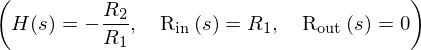

In [9]:
#Print out the Inverting Op Amp Theory
InvertingOpAmp.Theory()

.title InvertingOpAmp_TB
.subckt InvertingOpAmp Vin Vout
.subckt BasicOperationalAmplifier non_inverting_input inverting_input output
Rinput non_inverting_input inverting_input 10MegOhm
Egain 1 0 non_inverting_input inverting_input 100k
RP1 1 2 1kOhm
CP1 2 0 1.5915uF
Ebuffer 3 0 2 0 1
Rout 3 output 10Ohm
.ends BasicOperationalAmplifier
R1 Vin 2 20Ohm
R2 2 Vout 5Ohm
Xop 0 2 Vout BasicOperationalAmplifier
.ends InvertingOpAmp
XAmp Vin Vout InvertingOpAmp
RSload Vin 1 50Ohm
VSource 1 0 DC 0V AC SIN(0V 1V 50Hz 0s 0Hz)
RTload Vout 0 50Ohm



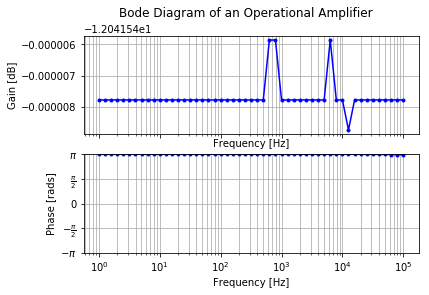

In [10]:
#create the Test Bench and Bind to this instance the InvertingOpAmp Topo
TB=OnePortOpAmpTB(InvertingOpAmp)
#Setup the Testbench; use a R1=20 Ohm,R2=5 Ohm and print the TB
TB.SetupCir(**{'R1':20, 'R2':5})
#Run the AC Bode Simulation
TB.Simulate()
#View Bode Simulation
TB.PlotResults()

# Noninverting

<img src="NonInveringOpAmp.png">

In [11]:
class NonInvertingOpAmp(SubCircuitFactory):
    """
    Non-Inverting OpAmp SubCir
    Termanals:
        Vin
        Vout
    Parms:
        R1
        R2
    """
    
    __name__='NonInvertingOpAmp'
    __nodes__=('Vin','Vout')
    
    def __init__(self, R1, R2):
        super().__init__()
        self.R1=R1; self.R2=R2
        
        self.R('1', '2', self.gnd, R1@u_Ω)
        self.R('2', '2', 'Vout', R2@u_Ω)
        
        self.subcircuit(BasicOperationalAmplifier())
        self.X('op', 'BasicOperationalAmplifier', 'Vin', '2', 'Vout')
    
    @staticmethod
    def Theory():
        """Practical Electrical Engineering Sergey Makarov; V-235"""
        R1, R2=symbols('R_1, R_2', real=True, postive=True)
        s=symbols('s')
        H=Function('H')(s); Rin=Function('R_in')(s); Rout=Function('R_out')(s)
        TF=Eq(H, 1+R2/R1); Rin=Eq(Rin, oo); Rout=Eq(Rout, 0)
        return TF, Rin, Rout
        


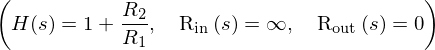

In [12]:
#Print out the NonInverting Op Amp Theory
NonInvertingOpAmp.Theory()

.title NonInvertingOpAmp_TB
.subckt NonInvertingOpAmp Vin Vout
.subckt BasicOperationalAmplifier non_inverting_input inverting_input output
Rinput non_inverting_input inverting_input 10MegOhm
Egain 1 0 non_inverting_input inverting_input 100k
RP1 1 2 1kOhm
CP1 2 0 1.5915uF
Ebuffer 3 0 2 0 1
Rout 3 output 10Ohm
.ends BasicOperationalAmplifier
R1 2 0 20Ohm
R2 2 Vout 5Ohm
Xop Vin 2 Vout BasicOperationalAmplifier
.ends NonInvertingOpAmp
XAmp Vin Vout NonInvertingOpAmp
RSload Vin 1 50Ohm
VSource 1 0 DC 0V AC SIN(0V 1V 50Hz 0s 0Hz)
RTload Vout 0 50Ohm



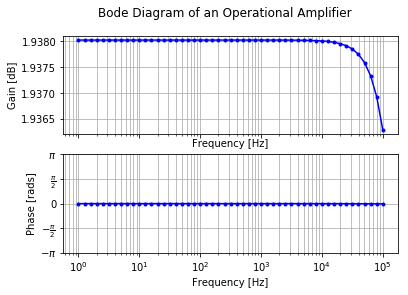

In [13]:
#create the Test Bench and Bind to this instance the NonInverting Topo
TB=OnePortOpAmpTB(NonInvertingOpAmp)
#Setup the Testbench; use a R1=20 Ohm,R2=5 Ohm and print the TB
TB.SetupCir(**{'R1':20, 'R2':5})
#Run the AC Bode Simulation
TB.Simulate()
#View Bode Simulation
TB.PlotResults()

# Miller Capactive Integrator 

<img src="MillerCapInt.png">

In [14]:
class MillerCapIntOpAmp(SubCircuitFactory):
    """
    Inverting OpAmp SubCir
    Termanals:
        Vin
        Vout
    Parms:
        R1[Ohms]
        C1[Fards]
    """
    
    __name__='MillerCapIntOpAmp'
    __nodes__=('Vin','Vout')
    
    def __init__(self, R1=1, C1=1):
        super().__init__()
        self.R1=R1; self.C1=C1
        
        self.R('1', 'Vin', '2', R1@u_Ω)
        self.C('1', '2', 'Vout', C1@u_F)
        
        self.subcircuit(BasicOperationalAmplifier())
        self.X('op', 'BasicOperationalAmplifier', self.gnd, '2', 'Vout')
        self.Theory()
    
    @staticmethod
    def Theory():
        R1, C1=symbols('R_1, C_1', real=True, postive=True)
        s=symbols('s')
        H=Function('H')(s)
        TF=Eq(H, -1/(s*C1*R1))
        return TF
    

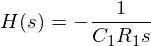

In [15]:
#Print out the MillerCapInt Op Amp Theory
MillerCapIntOpAmp.Theory()

.title MillerCapIntOpAmp_TB
.subckt MillerCapIntOpAmp Vin Vout
.subckt BasicOperationalAmplifier non_inverting_input inverting_input output
Rinput non_inverting_input inverting_input 10MegOhm
Egain 1 0 non_inverting_input inverting_input 100k
RP1 1 2 1kOhm
CP1 2 0 1.5915uF
Ebuffer 3 0 2 0 1
Rout 3 output 10Ohm
.ends BasicOperationalAmplifier
R1 Vin 2 20Ohm
C1 2 Vout 1e-05
Xop 0 2 Vout BasicOperationalAmplifier
.ends MillerCapIntOpAmp
XAmp Vin Vout MillerCapIntOpAmp
RSload Vin 1 50Ohm
VSource 1 0 DC 0V AC SIN(0V 1V 50Hz 0s 0Hz)
RTload Vout 0 50Ohm



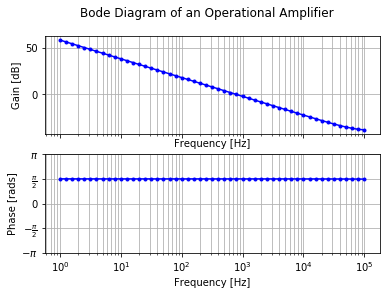

In [16]:
#create the Test Bench and Bind to this instance the MillerCapInt Topo
TB=OnePortOpAmpTB(MillerCapIntOpAmp)
#Setup the Testbench; use a R1=20 Ohm,C1=10 muF and print the TB
TB.SetupCir(**{'R1':20, 'C1':10e-6})
#Run the AC Bode Simulation
TB.Simulate()
#View Bode Simulation
TB.PlotResults()

# Miller Inductive Integrator 

<img src="MillerIndInt.png">

In [17]:
class MillerIndIntOpAmp(SubCircuitFactory):
    """
    Inverting OpAmp SubCir
    Termanals:
        Vin
        Vout
    Parms:
        R1[Ohms]
        L1[Henrys]
    """
    
    __name__='MillerIndIntOpAmp'
    __nodes__=('Vin','Vout')
    
    def __init__(self, R1=1, L1=1):
        super().__init__()
        self.R1=R1; self.L1=L1
        
        self.L('1', 'Vin', '2', L1@u_H)
        self.R('1', '2', 'Vout', R1@u_Ω)
        
        self.subcircuit(BasicOperationalAmplifier())
        self.X('op', 'BasicOperationalAmplifier', self.gnd, '2', 'Vout')
        self.Theory()
    
    @staticmethod
    def Theory():
        """Practical Electrical Engineering Sergey Makarov; V-235"""
        R1, L1=symbols('R_1, L_1', real=True, postive=True)
        s=symbols('s')
        H=Function('H')(s)
        TF=Eq(H, -R1/(s*L1))
        return TF
    

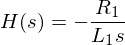

In [18]:
#Print out the MillerIndInt Op Amp Theory
MillerIndIntOpAmp.Theory()

.title MillerIndIntOpAmp_TB
.subckt MillerIndIntOpAmp Vin Vout
.subckt BasicOperationalAmplifier non_inverting_input inverting_input output
Rinput non_inverting_input inverting_input 10MegOhm
Egain 1 0 non_inverting_input inverting_input 100k
RP1 1 2 1kOhm
CP1 2 0 1.5915uF
Ebuffer 3 0 2 0 1
Rout 3 output 10Ohm
.ends BasicOperationalAmplifier
L1 Vin 2 1e-05H
R1 2 Vout 20Ohm
Xop 0 2 Vout BasicOperationalAmplifier
.ends MillerIndIntOpAmp
XAmp Vin Vout MillerIndIntOpAmp
RSload Vin 1 50Ohm
VSource 1 0 DC 0V AC SIN(0V 1V 50Hz 0s 0Hz)
RTload Vout 0 50Ohm



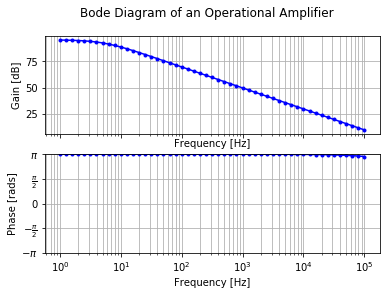

In [19]:
#create the Test Bench and Bind to this instance the MillerCapInt Topo
TB=OnePortOpAmpTB(MillerIndIntOpAmp)
#Setup the Testbench; use a R1=20 Ohm,L1=10 muH and print the TB
TB.SetupCir(**{'R1':20, 'L1':10e-6})
#Run the AC Bode Simulation
TB.Simulate()
#View Bode Simulation
TB.PlotResults()

#  Low Pass 1Pole

<img src="LowPass1P.png">

In [20]:
class LowPass1POpAmp(SubCircuitFactory):
    """
    Single Pole Low Pass OpAmp SubCir

    Termanals:
        Vin
        Vout
    Parms:
        R1[Ohms]
        R2[Ohms]
        C1[Farads]
    """
    
    __name__='LowPass1POpAmp'
    __nodes__=('Vin','Vout')
    
    def __init__(self, R1=1, R2=1, C1=1):
        super().__init__()
        self.R1=R1; self.R2=R2; self.C1=C1
        
        self.R('1', 'Vin', '2', R1@u_Ω)
        self.R('2', '2', 'Vout', R2@u_Ω)
        self.C('1', '2', 'Vout', C1@u_F)
        
        self.subcircuit(BasicOperationalAmplifier())
        #non, inv, out
        self.X('op', 'BasicOperationalAmplifier', 'Vin', '2', 'Vout')
        
    @staticmethod
    def Theory():
        R1, R2, C1=symbols('R_1, R_2, C_1', real=True, postive=True)
        s=symbols('s')
        H=Function('H')(s)
        TF=simplify(Eq(H, -(1/(s*C1+1/R2))/ R1))
        return TF


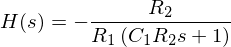

In [21]:
LowPass1POpAmp.Theory()

.title LowPass1POpAmp_TB
.subckt LowPass1POpAmp Vin Vout
.subckt BasicOperationalAmplifier non_inverting_input inverting_input output
Rinput non_inverting_input inverting_input 10MegOhm
Egain 1 0 non_inverting_input inverting_input 100k
RP1 1 2 1kOhm
CP1 2 0 1.5915uF
Ebuffer 3 0 2 0 1
Rout 3 output 10Ohm
.ends BasicOperationalAmplifier
R1 Vin 2 20Ohm
R2 2 Vout 5Ohm
C1 2 Vout 1e-05
Xop Vin 2 Vout BasicOperationalAmplifier
.ends LowPass1POpAmp
XAmp Vin Vout LowPass1POpAmp
RSload Vin 1 50Ohm
VSource 1 0 DC 0V AC SIN(0V 1V 50Hz 0s 0Hz)
RTload Vout 0 50Ohm



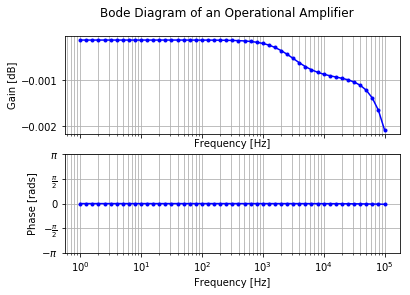

In [22]:
#create the Test Bench and Bind to this instance the LowPass1POpAmp Topo
TB=OnePortOpAmpTB(LowPass1POpAmp)
#Setup the Testbench; use a R1=20 Ohm, R2=5 Ohm,C1=10 muH and print the TB
TB.SetupCir(**{'R1':20, 'R2':5, 'C1':10e-6})
#Run the AC Bode Simulation
TB.Simulate()
#View Bode Simulation
TB.PlotResults()

# Miller Capacitive Differentiator 

<img src="MillerCapDiff.png">

In [23]:
class MillerCapDiff(SubCircuitFactory):
    """
    Miller Capacitive Differentiator  OpAmp SubCir
    Termanals:
        Vin
        Vout
    Parms:
        R1[Ohms]
        C1[Farads]
    """
    
    __name__='MillerCapDiff'
    __nodes__=('Vin','Vout')
    
    def __init__(self, R1=1, C1=1):
        super().__init__()
        self.R1=R1; self.C1=C1
        
        self.C('1', 'Vin', '2', C1@u_F)
        self.R('1', '2', 'Vout', R1@u_Ω)
        
        self.subcircuit(BasicOperationalAmplifier())
        self.X('op', 'BasicOperationalAmplifier', self.gnd, '2', 'Vout')
        self.Theory()
    
    @staticmethod
    def Theory():
        R1, C1=symbols('R_1, C_1', real=True, postive=True)
        s=symbols('s')
        H=Function('H')(s)
        TF=simplify(Eq(H, -R1/(1/s*C1)))
        return TF
    

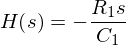

In [24]:
MillerCapDiff.Theory()

.title MillerCapDiff_TB
.subckt MillerCapDiff Vin Vout
.subckt BasicOperationalAmplifier non_inverting_input inverting_input output
Rinput non_inverting_input inverting_input 10MegOhm
Egain 1 0 non_inverting_input inverting_input 100k
RP1 1 2 1kOhm
CP1 2 0 1.5915uF
Ebuffer 3 0 2 0 1
Rout 3 output 10Ohm
.ends BasicOperationalAmplifier
C1 Vin 2 1e-05
R1 2 Vout 20Ohm
Xop 0 2 Vout BasicOperationalAmplifier
.ends MillerCapDiff
XAmp Vin Vout MillerCapDiff
RSload Vin 1 50Ohm
VSource 1 0 DC 0V AC SIN(0V 1V 50Hz 0s 0Hz)
RTload Vout 0 50Ohm



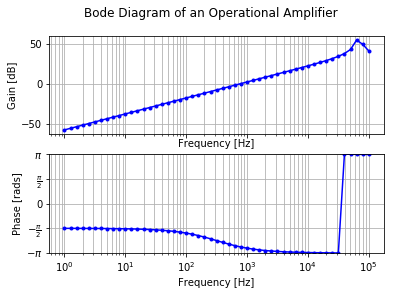

In [25]:
#create the Test Bench and Bind to this instance the MillerCapDiff Topo
TB=OnePortOpAmpTB(MillerCapDiff)
#Setup the Testbench; use a R1=20 Ohm,C1=10 muF and print the TB
TB.SetupCir(**{'R1':20, 'C1':10e-6})
#Run the AC Bode Simulation
TB.Simulate()
#View Bode Simulation
TB.PlotResults()

# Miller Inductive Differentiator 

<img src="MillerIndDiff.png">

In [26]:
class MillerIndDiff(SubCircuitFactory):
    """
    Miller Inductive Differentiator  OpAmp SubCir
    Termanals:
        Vin
        Vout
    Parms:
        R1[Ohms]
        L1[Henerys]
    """
    
    __name__='MillerIndDiff'
    __nodes__=('Vin','Vout')
    
    def __init__(self, R1=1, L1=1):
        super().__init__()
        self.R1=R1; self.L1=L1
        
        self.R('1', 'Vin', '2', R1@u_Ω)
        self.L('1', '2', 'Vout', L1@u_H)
        
        self.subcircuit(BasicOperationalAmplifier())
        self.X('op', 'BasicOperationalAmplifier', self.gnd, '2', 'Vout')
        self.Theory()
    
    @staticmethod
    def Theory():
        R1, L1=symbols('R_1, L_1', real=True, postive=True)
        s=symbols('s')
        H=Function('H')(s)
        TF=simplify(Eq(H, -s*L1/R1))
        return TF
    

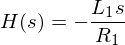

In [27]:
MillerIndDiff.Theory()

.title MillerIndDiff_TB
.subckt MillerIndDiff Vin Vout
.subckt BasicOperationalAmplifier non_inverting_input inverting_input output
Rinput non_inverting_input inverting_input 10MegOhm
Egain 1 0 non_inverting_input inverting_input 100k
RP1 1 2 1kOhm
CP1 2 0 1.5915uF
Ebuffer 3 0 2 0 1
Rout 3 output 10Ohm
.ends BasicOperationalAmplifier
R1 Vin 2 20Ohm
L1 2 Vout 1e-05H
Xop 0 2 Vout BasicOperationalAmplifier
.ends MillerIndDiff
XAmp Vin Vout MillerIndDiff
RSload Vin 1 50Ohm
VSource 1 0 DC 0V AC SIN(0V 1V 50Hz 0s 0Hz)
RTload Vout 0 50Ohm



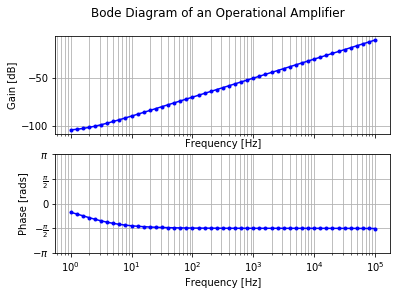

In [28]:
#create the Test Bench and Bind to this instance the MillerCapInt Topo
TB=OnePortOpAmpTB(MillerIndDiff)
#Setup the Testbench; use a R1=20 Ohm,L1=10 muH and print the TB
TB.SetupCir(**{'R1':20, 'L1':10e-6})
#Run the AC Bode Simulation
TB.Simulate()
#View Bode Simulation
TB.PlotResults()

# High Pass 1Zero

<img src="HighPass1Z.png">

In [29]:
class HighPass1ZOpAmp(SubCircuitFactory):
    """
    Single Pole Low Pass OpAmp SubCir

    Termanals:
        Vin
        Vout
    Parms:
        R1[Ohms]
        R2[Ohms]
        L1[Henerys]
    """
    
    __name__='HighPass1ZOpAmp'
    __nodes__=('Vin','Vout')
    
    def __init__(self, R1=1, R2=1, L1=1):
        super().__init__()
        self.R1=R1; self.R2=R2; self.L1=L1
        
        self.R('1', 'Vin', '2', R1@u_Ω)
        self.R('2', '2', 'Vout', R2@u_Ω)
        self.L('1', '2', 'Vout', L1@u_H)
        
        self.subcircuit(BasicOperationalAmplifier())
        #non, inv, out
        self.X('op', 'BasicOperationalAmplifier', 'Vin', '2', 'Vout')
        
    @staticmethod
    def Theory():
        R1, R2, L1=symbols('R_1, R_2, L_1', real=True, postive=True)
        s=symbols('s')
        H=Function('H')(s)
        TF=simplify(Eq(H, -(1/(1/R2+1/(s*L1)))/ R1))
        return TF


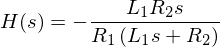

In [30]:
HighPass1ZOpAmp.Theory()

.title HighPass1ZOpAmp_TB
.subckt HighPass1ZOpAmp Vin Vout
.subckt BasicOperationalAmplifier non_inverting_input inverting_input output
Rinput non_inverting_input inverting_input 10MegOhm
Egain 1 0 non_inverting_input inverting_input 100k
RP1 1 2 1kOhm
CP1 2 0 1.5915uF
Ebuffer 3 0 2 0 1
Rout 3 output 10Ohm
.ends BasicOperationalAmplifier
R1 Vin 2 20Ohm
R2 2 Vout 5Ohm
L1 2 Vout 1e-05H
Xop Vin 2 Vout BasicOperationalAmplifier
.ends HighPass1ZOpAmp
XAmp Vin Vout HighPass1ZOpAmp
RSload Vin 1 50Ohm
VSource 1 0 DC 0V AC SIN(0V 1V 50Hz 0s 0Hz)
RTload Vout 0 50Ohm



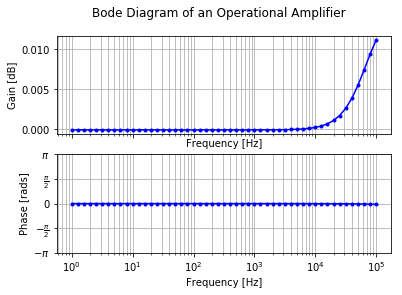

In [31]:
#create the Test Bench and Bind to this instance the HighPass1ZOpAmp Topo
TB=OnePortOpAmpTB(HighPass1ZOpAmp)
#Setup the Testbench; use a R1=20 Ohm,R2=5 Ohm, L1=10 muH and print the TB
TB.SetupCir(**{'R1':20, 'R2':5, 'L1':10e-6})
#Run the AC Bode Simulation
TB.Simulate()
#View Bode Simulation
TB.PlotResults()